In [1]:
import time
start = time.time()
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
import os

Seed değerimi giriyorum

In [2]:
torch.manual_seed(190401015)

MLP için class oluşturuyoruz.

Creating new class for MLP

In [3]:
class MLP(nn.Module):
    def __init__(self, insize, hidden1, hidden2, outputsize):
        super(MLP, self).__init__()
        self.hidden_layer1 = nn.Linear(insize, hidden1)
        self.hidden_layer2 = nn.Linear(hidden1, hidden2)
        self.output_layer = nn.Linear(hidden2, outputsize)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output = self.relu(self.hidden_layer1(x))
        output = self.relu(self.hidden_layer2(output))
        output = self.sigmoid(self.output_layer(output))
        return output

csv verimizi okuma 

reading the csv file

In [4]:
training_data = pd.read_csv("./cure_the_princess_train.csv")
val_data = pd.read_csv("./cure_the_princess_validation.csv")
test_data = pd.read_csv("./cure_the_princess_test.csv")
labels = training_data.columns.tolist()
num_of_classes = len(labels)
train_x = training_data.iloc[:, :-1].values
train_y = training_data.iloc[:, -1].values
val_x = val_data.iloc[:, :-1].values
val_y = val_data.iloc[:, -1].values
test_x = test_data.iloc[:, :-1].values
test_y = test_data.iloc[:, -1].values

CustomData adında class oluşturup okunan verilerimizi işleme

Creating new class called CustomData for using our data

In [5]:
class CustomData(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_data = CustomData(train_x, train_y)
validation_data = CustomData(val_x, val_y)
test_data = CustomData(test_x, test_y)

In [6]:
learning_rate = 0.0002786
epochnum = 2000
bsize = 16
insize = 13
hidden1 = 100
hidden2 = 50
outsize = 1
patience = 10

In [7]:
model = MLP(insize, hidden1, hidden2, outsize)

In [8]:
# Loss fonksiyonunu belirlemek / Determining loss function
criterion = nn.BCELoss()

# Optimizer'ı belirlemek / Determining optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=bsize, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validation_data, batch_size=bsize, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=bsize, shuffle=False)

In [10]:
train_loss_list = []
valid_loss_list = []

In [11]:
patience_counter = 0
best_value_loss = None
for epoch in range(epochnum):
    train_loss = 0.0
    train_count = 0.0
    valid_loss = 0.0

    # Eğitim verileri üzerinde eğitim yapmak / Training
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        train_count += 1
        train_loss += loss.item()

    # Doğrulama verileri üzerinde test yapmak / Testing
    with torch.no_grad():
        model.eval()
        for data, target in valid_loader:
            output = model(data)
            loss = criterion(output, target.unsqueeze(1).float())
            valid_loss += loss.item()
    
    model.train()
    # Loss değerlerini kaydetmek / Saving the Loss values
    train_loss = train_loss / train_count
    valid_loss = valid_loss / len(valid_loader)
        
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch + 1, train_loss, valid_loss))
    
    val_score = valid_loss
    if best_value_loss is None:
        best_value_loss = val_score # hafızada patience boyu tutmaya başla
        torch.save(model.state_dict(), "checkpoint.pt")
    elif best_value_loss < val_score: # patience counter
        patience_counter = patience_counter + 1
        print("Earlystopping Patience Counter:",patience_counter)
        #if patience_counter == patience:
            #break
    else:
        best_value_loss = val_score
        torch.save(model.state_dict(), "checkpoint.pt") # to keep the best model
        patience_counter = 0

Epoch: 1 	Training Loss: 0.734405 	Validation Loss: 0.696810
Epoch: 2 	Training Loss: 0.702557 	Validation Loss: 0.667388
Epoch: 3 	Training Loss: 0.676456 	Validation Loss: 0.645193
Epoch: 4 	Training Loss: 0.655148 	Validation Loss: 0.620331
Epoch: 5 	Training Loss: 0.633830 	Validation Loss: 0.599972
Epoch: 6 	Training Loss: 0.618530 	Validation Loss: 0.581816
Epoch: 7 	Training Loss: 0.602851 	Validation Loss: 0.566221
Epoch: 8 	Training Loss: 0.590376 	Validation Loss: 0.553089
Epoch: 9 	Training Loss: 0.579019 	Validation Loss: 0.540538
Epoch: 10 	Training Loss: 0.567324 	Validation Loss: 0.528441
Epoch: 11 	Training Loss: 0.558875 	Validation Loss: 0.519926
Epoch: 12 	Training Loss: 0.549942 	Validation Loss: 0.508993
Epoch: 13 	Training Loss: 0.540281 	Validation Loss: 0.498593
Epoch: 14 	Training Loss: 0.533203 	Validation Loss: 0.494444
Epoch: 15 	Training Loss: 0.522945 	Validation Loss: 0.482640
Epoch: 16 	Training Loss: 0.518159 	Validation Loss: 0.475905
Epoch: 17 	Traini

Epoch: 137 	Training Loss: 0.225936 	Validation Loss: 0.205483
Epoch: 138 	Training Loss: 0.226190 	Validation Loss: 0.205512
Earlystopping Patience Counter: 1
Epoch: 139 	Training Loss: 0.225730 	Validation Loss: 0.204768
Epoch: 140 	Training Loss: 0.223528 	Validation Loss: 0.205692
Earlystopping Patience Counter: 1
Epoch: 141 	Training Loss: 0.223382 	Validation Loss: 0.204248
Epoch: 142 	Training Loss: 0.222639 	Validation Loss: 0.204214
Epoch: 143 	Training Loss: 0.224982 	Validation Loss: 0.206059
Earlystopping Patience Counter: 1
Epoch: 144 	Training Loss: 0.221930 	Validation Loss: 0.203008
Epoch: 145 	Training Loss: 0.222546 	Validation Loss: 0.203668
Earlystopping Patience Counter: 1
Epoch: 146 	Training Loss: 0.219968 	Validation Loss: 0.202042
Epoch: 147 	Training Loss: 0.220073 	Validation Loss: 0.201804
Epoch: 148 	Training Loss: 0.222830 	Validation Loss: 0.201762
Epoch: 149 	Training Loss: 0.218872 	Validation Loss: 0.201390
Epoch: 150 	Training Loss: 0.221509 	Validati

Epoch: 249 	Training Loss: 0.175223 	Validation Loss: 0.177922
Earlystopping Patience Counter: 2
Epoch: 250 	Training Loss: 0.173446 	Validation Loss: 0.177517
Earlystopping Patience Counter: 3
Epoch: 251 	Training Loss: 0.173290 	Validation Loss: 0.177304
Earlystopping Patience Counter: 4
Epoch: 252 	Training Loss: 0.174544 	Validation Loss: 0.179541
Earlystopping Patience Counter: 5
Epoch: 253 	Training Loss: 0.172072 	Validation Loss: 0.178568
Earlystopping Patience Counter: 6
Epoch: 254 	Training Loss: 0.172465 	Validation Loss: 0.177240
Epoch: 255 	Training Loss: 0.177229 	Validation Loss: 0.179295
Earlystopping Patience Counter: 1
Epoch: 256 	Training Loss: 0.172132 	Validation Loss: 0.176920
Epoch: 257 	Training Loss: 0.175535 	Validation Loss: 0.182231
Earlystopping Patience Counter: 1
Epoch: 258 	Training Loss: 0.172126 	Validation Loss: 0.176201
Epoch: 259 	Training Loss: 0.177987 	Validation Loss: 0.177847
Earlystopping Patience Counter: 1
Epoch: 260 	Training Loss: 0.169545

Epoch: 347 	Training Loss: 0.148414 	Validation Loss: 0.164661
Earlystopping Patience Counter: 1
Epoch: 348 	Training Loss: 0.148036 	Validation Loss: 0.164968
Earlystopping Patience Counter: 2
Epoch: 349 	Training Loss: 0.147005 	Validation Loss: 0.165819
Earlystopping Patience Counter: 3
Epoch: 350 	Training Loss: 0.146999 	Validation Loss: 0.164805
Earlystopping Patience Counter: 4
Epoch: 351 	Training Loss: 0.146766 	Validation Loss: 0.164253
Epoch: 352 	Training Loss: 0.146279 	Validation Loss: 0.164082
Epoch: 353 	Training Loss: 0.146692 	Validation Loss: 0.165902
Earlystopping Patience Counter: 1
Epoch: 354 	Training Loss: 0.145533 	Validation Loss: 0.165307
Earlystopping Patience Counter: 2
Epoch: 355 	Training Loss: 0.145957 	Validation Loss: 0.164796
Earlystopping Patience Counter: 3
Epoch: 356 	Training Loss: 0.146017 	Validation Loss: 0.165138
Earlystopping Patience Counter: 4
Epoch: 357 	Training Loss: 0.144736 	Validation Loss: 0.164911
Earlystopping Patience Counter: 5
E

Epoch: 444 	Training Loss: 0.129340 	Validation Loss: 0.158181
Earlystopping Patience Counter: 1
Epoch: 445 	Training Loss: 0.128678 	Validation Loss: 0.160363
Earlystopping Patience Counter: 2
Epoch: 446 	Training Loss: 0.127812 	Validation Loss: 0.158266
Earlystopping Patience Counter: 3
Epoch: 447 	Training Loss: 0.128936 	Validation Loss: 0.159221
Earlystopping Patience Counter: 4
Epoch: 448 	Training Loss: 0.129569 	Validation Loss: 0.159356
Earlystopping Patience Counter: 5
Epoch: 449 	Training Loss: 0.127446 	Validation Loss: 0.157837
Epoch: 450 	Training Loss: 0.126734 	Validation Loss: 0.158419
Earlystopping Patience Counter: 1
Epoch: 451 	Training Loss: 0.129209 	Validation Loss: 0.157641
Epoch: 452 	Training Loss: 0.130765 	Validation Loss: 0.157815
Earlystopping Patience Counter: 1
Epoch: 453 	Training Loss: 0.126632 	Validation Loss: 0.158211
Earlystopping Patience Counter: 2
Epoch: 454 	Training Loss: 0.126566 	Validation Loss: 0.158139
Earlystopping Patience Counter: 3
E

Epoch: 542 	Training Loss: 0.112934 	Validation Loss: 0.153006
Earlystopping Patience Counter: 5
Epoch: 543 	Training Loss: 0.112253 	Validation Loss: 0.153391
Earlystopping Patience Counter: 6
Epoch: 544 	Training Loss: 0.112536 	Validation Loss: 0.152706
Earlystopping Patience Counter: 7
Epoch: 545 	Training Loss: 0.111741 	Validation Loss: 0.154640
Earlystopping Patience Counter: 8
Epoch: 546 	Training Loss: 0.112018 	Validation Loss: 0.153417
Earlystopping Patience Counter: 9
Epoch: 547 	Training Loss: 0.114657 	Validation Loss: 0.152779
Earlystopping Patience Counter: 10
Epoch: 548 	Training Loss: 0.111708 	Validation Loss: 0.152822
Earlystopping Patience Counter: 11
Epoch: 549 	Training Loss: 0.112338 	Validation Loss: 0.152582
Earlystopping Patience Counter: 12
Epoch: 550 	Training Loss: 0.111426 	Validation Loss: 0.152820
Earlystopping Patience Counter: 13
Epoch: 551 	Training Loss: 0.113093 	Validation Loss: 0.154763
Earlystopping Patience Counter: 14
Epoch: 552 	Training Loss

Epoch: 640 	Training Loss: 0.100021 	Validation Loss: 0.149612
Epoch: 641 	Training Loss: 0.100279 	Validation Loss: 0.149669
Earlystopping Patience Counter: 1
Epoch: 642 	Training Loss: 0.100915 	Validation Loss: 0.149409
Epoch: 643 	Training Loss: 0.100116 	Validation Loss: 0.149503
Earlystopping Patience Counter: 1
Epoch: 644 	Training Loss: 0.099226 	Validation Loss: 0.149828
Earlystopping Patience Counter: 2
Epoch: 645 	Training Loss: 0.100495 	Validation Loss: 0.149039
Epoch: 646 	Training Loss: 0.100205 	Validation Loss: 0.149462
Earlystopping Patience Counter: 1
Epoch: 647 	Training Loss: 0.104158 	Validation Loss: 0.161308
Earlystopping Patience Counter: 2
Epoch: 648 	Training Loss: 0.100776 	Validation Loss: 0.150561
Earlystopping Patience Counter: 3
Epoch: 649 	Training Loss: 0.100568 	Validation Loss: 0.150808
Earlystopping Patience Counter: 4
Epoch: 650 	Training Loss: 0.099484 	Validation Loss: 0.149862
Earlystopping Patience Counter: 5
Epoch: 651 	Training Loss: 0.109478

Epoch: 737 	Training Loss: 0.090341 	Validation Loss: 0.151093
Earlystopping Patience Counter: 16
Epoch: 738 	Training Loss: 0.090512 	Validation Loss: 0.147098
Earlystopping Patience Counter: 17
Epoch: 739 	Training Loss: 0.089946 	Validation Loss: 0.147348
Earlystopping Patience Counter: 18
Epoch: 740 	Training Loss: 0.089516 	Validation Loss: 0.147788
Earlystopping Patience Counter: 19
Epoch: 741 	Training Loss: 0.090172 	Validation Loss: 0.146547
Earlystopping Patience Counter: 20
Epoch: 742 	Training Loss: 0.090587 	Validation Loss: 0.150211
Earlystopping Patience Counter: 21
Epoch: 743 	Training Loss: 0.090124 	Validation Loss: 0.148055
Earlystopping Patience Counter: 22
Epoch: 744 	Training Loss: 0.089933 	Validation Loss: 0.147377
Earlystopping Patience Counter: 23
Epoch: 745 	Training Loss: 0.089318 	Validation Loss: 0.147580
Earlystopping Patience Counter: 24
Epoch: 746 	Training Loss: 0.091812 	Validation Loss: 0.147244
Earlystopping Patience Counter: 25
Epoch: 747 	Training

Epoch: 834 	Training Loss: 0.081339 	Validation Loss: 0.149887
Earlystopping Patience Counter: 27
Epoch: 835 	Training Loss: 0.083278 	Validation Loss: 0.155534
Earlystopping Patience Counter: 28
Epoch: 836 	Training Loss: 0.082573 	Validation Loss: 0.147021
Earlystopping Patience Counter: 29
Epoch: 837 	Training Loss: 0.082112 	Validation Loss: 0.147209
Earlystopping Patience Counter: 30
Epoch: 838 	Training Loss: 0.081082 	Validation Loss: 0.148158
Earlystopping Patience Counter: 31
Epoch: 839 	Training Loss: 0.081538 	Validation Loss: 0.150227
Earlystopping Patience Counter: 32
Epoch: 840 	Training Loss: 0.084302 	Validation Loss: 0.145661
Epoch: 841 	Training Loss: 0.080245 	Validation Loss: 0.145420
Epoch: 842 	Training Loss: 0.080959 	Validation Loss: 0.146209
Earlystopping Patience Counter: 1
Epoch: 843 	Training Loss: 0.080330 	Validation Loss: 0.147226
Earlystopping Patience Counter: 2
Epoch: 844 	Training Loss: 0.081637 	Validation Loss: 0.145741
Earlystopping Patience Counte

Epoch: 929 	Training Loss: 0.074119 	Validation Loss: 0.146462
Earlystopping Patience Counter: 26
Epoch: 930 	Training Loss: 0.074770 	Validation Loss: 0.148205
Earlystopping Patience Counter: 27
Epoch: 931 	Training Loss: 0.074219 	Validation Loss: 0.147022
Earlystopping Patience Counter: 28
Epoch: 932 	Training Loss: 0.075823 	Validation Loss: 0.146316
Earlystopping Patience Counter: 29
Epoch: 933 	Training Loss: 0.073666 	Validation Loss: 0.148765
Earlystopping Patience Counter: 30
Epoch: 934 	Training Loss: 0.073468 	Validation Loss: 0.146940
Earlystopping Patience Counter: 31
Epoch: 935 	Training Loss: 0.076052 	Validation Loss: 0.150055
Earlystopping Patience Counter: 32
Epoch: 936 	Training Loss: 0.073972 	Validation Loss: 0.147818
Earlystopping Patience Counter: 33
Epoch: 937 	Training Loss: 0.073447 	Validation Loss: 0.146226
Earlystopping Patience Counter: 34
Epoch: 938 	Training Loss: 0.074072 	Validation Loss: 0.146936
Earlystopping Patience Counter: 35
Epoch: 939 	Training

Epoch: 1022 	Training Loss: 0.067501 	Validation Loss: 0.147258
Earlystopping Patience Counter: 119
Epoch: 1023 	Training Loss: 0.067441 	Validation Loss: 0.147019
Earlystopping Patience Counter: 120
Epoch: 1024 	Training Loss: 0.067057 	Validation Loss: 0.147865
Earlystopping Patience Counter: 121
Epoch: 1025 	Training Loss: 0.069468 	Validation Loss: 0.154262
Earlystopping Patience Counter: 122
Epoch: 1026 	Training Loss: 0.067779 	Validation Loss: 0.148414
Earlystopping Patience Counter: 123
Epoch: 1027 	Training Loss: 0.067407 	Validation Loss: 0.147146
Earlystopping Patience Counter: 124
Epoch: 1028 	Training Loss: 0.068257 	Validation Loss: 0.146353
Earlystopping Patience Counter: 125
Epoch: 1029 	Training Loss: 0.066741 	Validation Loss: 0.146070
Earlystopping Patience Counter: 126
Epoch: 1030 	Training Loss: 0.066949 	Validation Loss: 0.147306
Earlystopping Patience Counter: 127
Epoch: 1031 	Training Loss: 0.067797 	Validation Loss: 0.148905
Earlystopping Patience Counter: 128


Epoch: 1114 	Training Loss: 0.061821 	Validation Loss: 0.148428
Earlystopping Patience Counter: 211
Epoch: 1115 	Training Loss: 0.063310 	Validation Loss: 0.152060
Earlystopping Patience Counter: 212
Epoch: 1116 	Training Loss: 0.063766 	Validation Loss: 0.149143
Earlystopping Patience Counter: 213
Epoch: 1117 	Training Loss: 0.062545 	Validation Loss: 0.149499
Earlystopping Patience Counter: 214
Epoch: 1118 	Training Loss: 0.062054 	Validation Loss: 0.148397
Earlystopping Patience Counter: 215
Epoch: 1119 	Training Loss: 0.062745 	Validation Loss: 0.147965
Earlystopping Patience Counter: 216
Epoch: 1120 	Training Loss: 0.062685 	Validation Loss: 0.148506
Earlystopping Patience Counter: 217
Epoch: 1121 	Training Loss: 0.063008 	Validation Loss: 0.153038
Earlystopping Patience Counter: 218
Epoch: 1122 	Training Loss: 0.062875 	Validation Loss: 0.148052
Earlystopping Patience Counter: 219
Epoch: 1123 	Training Loss: 0.061977 	Validation Loss: 0.149635
Earlystopping Patience Counter: 220


Epoch: 1206 	Training Loss: 0.057398 	Validation Loss: 0.153173
Earlystopping Patience Counter: 303
Epoch: 1207 	Training Loss: 0.057164 	Validation Loss: 0.150770
Earlystopping Patience Counter: 304
Epoch: 1208 	Training Loss: 0.056854 	Validation Loss: 0.151680
Earlystopping Patience Counter: 305
Epoch: 1209 	Training Loss: 0.056720 	Validation Loss: 0.150535
Earlystopping Patience Counter: 306
Epoch: 1210 	Training Loss: 0.056936 	Validation Loss: 0.149744
Earlystopping Patience Counter: 307
Epoch: 1211 	Training Loss: 0.057724 	Validation Loss: 0.152367
Earlystopping Patience Counter: 308
Epoch: 1212 	Training Loss: 0.057928 	Validation Loss: 0.152031
Earlystopping Patience Counter: 309
Epoch: 1213 	Training Loss: 0.056439 	Validation Loss: 0.150583
Earlystopping Patience Counter: 310
Epoch: 1214 	Training Loss: 0.056977 	Validation Loss: 0.152521
Earlystopping Patience Counter: 311
Epoch: 1215 	Training Loss: 0.057354 	Validation Loss: 0.153809
Earlystopping Patience Counter: 312


Epoch: 1301 	Training Loss: 0.052724 	Validation Loss: 0.156399
Earlystopping Patience Counter: 398
Epoch: 1302 	Training Loss: 0.051959 	Validation Loss: 0.153244
Earlystopping Patience Counter: 399
Epoch: 1303 	Training Loss: 0.053280 	Validation Loss: 0.153265
Earlystopping Patience Counter: 400
Epoch: 1304 	Training Loss: 0.051823 	Validation Loss: 0.154956
Earlystopping Patience Counter: 401
Epoch: 1305 	Training Loss: 0.052430 	Validation Loss: 0.153253
Earlystopping Patience Counter: 402
Epoch: 1306 	Training Loss: 0.052642 	Validation Loss: 0.156764
Earlystopping Patience Counter: 403
Epoch: 1307 	Training Loss: 0.051613 	Validation Loss: 0.158038
Earlystopping Patience Counter: 404
Epoch: 1308 	Training Loss: 0.050891 	Validation Loss: 0.155558
Earlystopping Patience Counter: 405
Epoch: 1309 	Training Loss: 0.051921 	Validation Loss: 0.154556
Earlystopping Patience Counter: 406
Epoch: 1310 	Training Loss: 0.053036 	Validation Loss: 0.156625
Earlystopping Patience Counter: 407


Epoch: 1385 	Training Loss: 0.048106 	Validation Loss: 0.155201
Earlystopping Patience Counter: 482
Epoch: 1386 	Training Loss: 0.048941 	Validation Loss: 0.154925
Earlystopping Patience Counter: 483
Epoch: 1387 	Training Loss: 0.048412 	Validation Loss: 0.156004
Earlystopping Patience Counter: 484
Epoch: 1388 	Training Loss: 0.048087 	Validation Loss: 0.155392
Earlystopping Patience Counter: 485
Epoch: 1389 	Training Loss: 0.048042 	Validation Loss: 0.156861
Earlystopping Patience Counter: 486
Epoch: 1390 	Training Loss: 0.048245 	Validation Loss: 0.158526
Earlystopping Patience Counter: 487
Epoch: 1391 	Training Loss: 0.048080 	Validation Loss: 0.155705
Earlystopping Patience Counter: 488
Epoch: 1392 	Training Loss: 0.048648 	Validation Loss: 0.158168
Earlystopping Patience Counter: 489
Epoch: 1393 	Training Loss: 0.048258 	Validation Loss: 0.157865
Earlystopping Patience Counter: 490
Epoch: 1394 	Training Loss: 0.047592 	Validation Loss: 0.156028
Earlystopping Patience Counter: 491


Epoch: 1468 	Training Loss: 0.044489 	Validation Loss: 0.158128
Earlystopping Patience Counter: 565
Epoch: 1469 	Training Loss: 0.044750 	Validation Loss: 0.159325
Earlystopping Patience Counter: 566
Epoch: 1470 	Training Loss: 0.044651 	Validation Loss: 0.159568
Earlystopping Patience Counter: 567
Epoch: 1471 	Training Loss: 0.044941 	Validation Loss: 0.159432
Earlystopping Patience Counter: 568
Epoch: 1472 	Training Loss: 0.044727 	Validation Loss: 0.160939
Earlystopping Patience Counter: 569
Epoch: 1473 	Training Loss: 0.045259 	Validation Loss: 0.161631
Earlystopping Patience Counter: 570
Epoch: 1474 	Training Loss: 0.045237 	Validation Loss: 0.158994
Earlystopping Patience Counter: 571
Epoch: 1475 	Training Loss: 0.044353 	Validation Loss: 0.159704
Earlystopping Patience Counter: 572
Epoch: 1476 	Training Loss: 0.045130 	Validation Loss: 0.161356
Earlystopping Patience Counter: 573
Epoch: 1477 	Training Loss: 0.044028 	Validation Loss: 0.162709
Earlystopping Patience Counter: 574


Epoch: 1552 	Training Loss: 0.041505 	Validation Loss: 0.161445
Earlystopping Patience Counter: 649
Epoch: 1553 	Training Loss: 0.041167 	Validation Loss: 0.164511
Earlystopping Patience Counter: 650
Epoch: 1554 	Training Loss: 0.040693 	Validation Loss: 0.161273
Earlystopping Patience Counter: 651
Epoch: 1555 	Training Loss: 0.041085 	Validation Loss: 0.162192
Earlystopping Patience Counter: 652
Epoch: 1556 	Training Loss: 0.041573 	Validation Loss: 0.162342
Earlystopping Patience Counter: 653
Epoch: 1557 	Training Loss: 0.041042 	Validation Loss: 0.161999
Earlystopping Patience Counter: 654
Epoch: 1558 	Training Loss: 0.041203 	Validation Loss: 0.161849
Earlystopping Patience Counter: 655
Epoch: 1559 	Training Loss: 0.040968 	Validation Loss: 0.161733
Earlystopping Patience Counter: 656
Epoch: 1560 	Training Loss: 0.040631 	Validation Loss: 0.166692
Earlystopping Patience Counter: 657
Epoch: 1561 	Training Loss: 0.040562 	Validation Loss: 0.162983
Earlystopping Patience Counter: 658


Epoch: 1636 	Training Loss: 0.038276 	Validation Loss: 0.164452
Earlystopping Patience Counter: 733
Epoch: 1637 	Training Loss: 0.038574 	Validation Loss: 0.165359
Earlystopping Patience Counter: 734
Epoch: 1638 	Training Loss: 0.038003 	Validation Loss: 0.167933
Earlystopping Patience Counter: 735
Epoch: 1639 	Training Loss: 0.037774 	Validation Loss: 0.164131
Earlystopping Patience Counter: 736
Epoch: 1640 	Training Loss: 0.038315 	Validation Loss: 0.164996
Earlystopping Patience Counter: 737
Epoch: 1641 	Training Loss: 0.044919 	Validation Loss: 0.177657
Earlystopping Patience Counter: 738
Epoch: 1642 	Training Loss: 0.038550 	Validation Loss: 0.166403
Earlystopping Patience Counter: 739
Epoch: 1643 	Training Loss: 0.038050 	Validation Loss: 0.167151
Earlystopping Patience Counter: 740
Epoch: 1644 	Training Loss: 0.040156 	Validation Loss: 0.175432
Earlystopping Patience Counter: 741
Epoch: 1645 	Training Loss: 0.039130 	Validation Loss: 0.167988
Earlystopping Patience Counter: 742


Epoch: 1720 	Training Loss: 0.035787 	Validation Loss: 0.173557
Earlystopping Patience Counter: 817
Epoch: 1721 	Training Loss: 0.035909 	Validation Loss: 0.172312
Earlystopping Patience Counter: 818
Epoch: 1722 	Training Loss: 0.035140 	Validation Loss: 0.169981
Earlystopping Patience Counter: 819
Epoch: 1723 	Training Loss: 0.035677 	Validation Loss: 0.167494
Earlystopping Patience Counter: 820
Epoch: 1724 	Training Loss: 0.036068 	Validation Loss: 0.168470
Earlystopping Patience Counter: 821
Epoch: 1725 	Training Loss: 0.035515 	Validation Loss: 0.169700
Earlystopping Patience Counter: 822
Epoch: 1726 	Training Loss: 0.035190 	Validation Loss: 0.168123
Earlystopping Patience Counter: 823
Epoch: 1727 	Training Loss: 0.035204 	Validation Loss: 0.168246
Earlystopping Patience Counter: 824
Epoch: 1728 	Training Loss: 0.034986 	Validation Loss: 0.168461
Earlystopping Patience Counter: 825
Epoch: 1729 	Training Loss: 0.034766 	Validation Loss: 0.171516
Earlystopping Patience Counter: 826


Epoch: 1804 	Training Loss: 0.032743 	Validation Loss: 0.171532
Earlystopping Patience Counter: 901
Epoch: 1805 	Training Loss: 0.032533 	Validation Loss: 0.171206
Earlystopping Patience Counter: 902
Epoch: 1806 	Training Loss: 0.034629 	Validation Loss: 0.171282
Earlystopping Patience Counter: 903
Epoch: 1807 	Training Loss: 0.033320 	Validation Loss: 0.172514
Earlystopping Patience Counter: 904
Epoch: 1808 	Training Loss: 0.032810 	Validation Loss: 0.173641
Earlystopping Patience Counter: 905
Epoch: 1809 	Training Loss: 0.032440 	Validation Loss: 0.170370
Earlystopping Patience Counter: 906
Epoch: 1810 	Training Loss: 0.032413 	Validation Loss: 0.171531
Earlystopping Patience Counter: 907
Epoch: 1811 	Training Loss: 0.032463 	Validation Loss: 0.173404
Earlystopping Patience Counter: 908
Epoch: 1812 	Training Loss: 0.032385 	Validation Loss: 0.170745
Earlystopping Patience Counter: 909
Epoch: 1813 	Training Loss: 0.032756 	Validation Loss: 0.174520
Earlystopping Patience Counter: 910


Epoch: 1887 	Training Loss: 0.030259 	Validation Loss: 0.176466
Earlystopping Patience Counter: 984
Epoch: 1888 	Training Loss: 0.030246 	Validation Loss: 0.174322
Earlystopping Patience Counter: 985
Epoch: 1889 	Training Loss: 0.030427 	Validation Loss: 0.174199
Earlystopping Patience Counter: 986
Epoch: 1890 	Training Loss: 0.030082 	Validation Loss: 0.181006
Earlystopping Patience Counter: 987
Epoch: 1891 	Training Loss: 0.030394 	Validation Loss: 0.174922
Earlystopping Patience Counter: 988
Epoch: 1892 	Training Loss: 0.030054 	Validation Loss: 0.181079
Earlystopping Patience Counter: 989
Epoch: 1893 	Training Loss: 0.030991 	Validation Loss: 0.176741
Earlystopping Patience Counter: 990
Epoch: 1894 	Training Loss: 0.030132 	Validation Loss: 0.178621
Earlystopping Patience Counter: 991
Epoch: 1895 	Training Loss: 0.030296 	Validation Loss: 0.174889
Earlystopping Patience Counter: 992
Epoch: 1896 	Training Loss: 0.030115 	Validation Loss: 0.174386
Earlystopping Patience Counter: 993


Epoch: 1971 	Training Loss: 0.028477 	Validation Loss: 0.179961
Earlystopping Patience Counter: 1068
Epoch: 1972 	Training Loss: 0.028028 	Validation Loss: 0.176685
Earlystopping Patience Counter: 1069
Epoch: 1973 	Training Loss: 0.028065 	Validation Loss: 0.178179
Earlystopping Patience Counter: 1070
Epoch: 1974 	Training Loss: 0.028956 	Validation Loss: 0.185959
Earlystopping Patience Counter: 1071
Epoch: 1975 	Training Loss: 0.027928 	Validation Loss: 0.176770
Earlystopping Patience Counter: 1072
Epoch: 1976 	Training Loss: 0.031066 	Validation Loss: 0.176959
Earlystopping Patience Counter: 1073
Epoch: 1977 	Training Loss: 0.030672 	Validation Loss: 0.185412
Earlystopping Patience Counter: 1074
Epoch: 1978 	Training Loss: 0.028254 	Validation Loss: 0.178004
Earlystopping Patience Counter: 1075
Epoch: 1979 	Training Loss: 0.027788 	Validation Loss: 0.177517
Earlystopping Patience Counter: 1076
Epoch: 1980 	Training Loss: 0.027949 	Validation Loss: 0.180741
Earlystopping Patience Coun

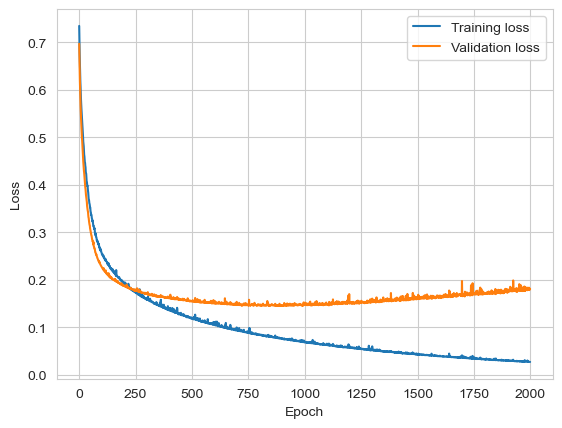

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.plot(train_loss_list, label="Training loss")
plt.plot(valid_loss_list, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

model.load_state_dict(torch.load('checkpoint.pt'))

preds = []
tlabels = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = torch.round(outputs)
        preds.extend(predicted.detach().cpu().numpy())
        tlabels.extend(labels.detach().cpu().numpy())

accuracy = accuracy_score(tlabels, preds)
f1 = f1_score(tlabels, preds)
precision = precision_score(tlabels, preds)
recall = recall_score(tlabels, preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Accuracy: 0.9508
F1 score: 0.9500
Precision: 0.9704
Recall: 0.9304


In [14]:
end = time.time()
elapsed = end - start
print("Elapsed:", f'{elapsed:.2f}', "secs")

Elapsed: 32.02 secs
